# Simulation of song/brain evolution selecting for information transmission

In [1]:
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import sys

from record_0_main import smlt_ma
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

In [2]:
song_modes = ['Q', 'S', 'P']

def sample_song(pi, nt):
    """
    Sample a 3-mode Markov song.
    
    pi: transition matrix (row = from, col = to)
    """
    # get stationary distribution to use for initial condition
#     evs, evecs = linalg.eig(pi, left=True, right=False)
#     idx_ev_1 = np.argmin(np.abs(evs-1))
#     p_0 = evecs[:, idx_ev_1]
#     p_0 = np.real(p_0)
#     if np.sum(p_0) < 1:
#         p_0 *= -1
#     p_0 /= np.sum(p_0)
    
    song = np.repeat('', nt)
    
    # song[0] = np.random.choice(song_modes, p=p_0)
    song[0] = np.random.choice(song_modes)
    
    for t_ in range(1, nt):
        p_next = pi[song_modes.index(song[t_-1]), :]
        song[t_] = np.random.choice(song_modes, p=p_next)
        
    i_s = song == 'S'
    i_p = song == 'P'
    
    return i_s, i_p, song

def get_h_naive(rs, nbin, base=2):
    """Naive netropy of estimate (i.e. not corrected for sampling)."""
    nnrn = rs.shape[1]
    bins = [np.linspace(0, 1, nbin) for r in rs.T]
    
    p_singles = [np.histogram(rs[:, cnrn], bins[cnrn], density=True)[0] for cnrn in range(nnrn)]
    
    p_joint = np.histogramdd(rs, bins, density=True)[0]
    
    h_singles = [stats.entropy(p_single/p_single.sum(), base=base) for p_single in p_singles]
    
    h_joint = stats.entropy(p_joint.flatten()/p_joint.sum(), base=base)
    
    return h_joint, h_singles

def get_joint_mi(pi, nrn_param, nt, nbin):
    """Estimate mutual info btwn song and joint neural response."""
    i_s, i_p, song = sample_song(pi, nt)
    rs = smlt_ma(i_s, i_p, nrn_param, DT)
    rs /= rs.max(axis=0)
    
    h_joint, h_singles = get_h_naive(rs, nbin, base=2)
    
    return h_joint

def evolve_pi(pi, rate_pi, alpha_min=.001):
    """Sample new transition matrix given prev transition matrix."""
    pi_new = np.nan*np.eye(3)
    
    for row in range(3):
        alpha = pi[row, :]/rate_pi
        # fix numerical erros if alpha 0
        alpha[alpha < alpha_min] = alpha_min
        pi_new[row, :] = np.random.dirichlet(alpha)
        
    return pi_new

# def evolve_nrn_param(nrn_param, rate_tau_r, rate_tau_a, rate_x, eps=.001):
#     """Sample new neural parameters."""
#     nnrn = len(nrn_param['TAU_R'])
#     nrn_param_new = {
#         'TAU_R': np.nan*np.zeros(nnrn),
#         'TAU_A': np.nan*np.zeros(nnrn),
#         'X_S': np.nan*np.zeros(nnrn),
#         'X_P': np.nan*np.zeros(nnrn),
#     }
    
#     # TAU_R
#     for cnrn in range(nnrn):
#         shape = nrn_param['TAU_R'][cnrn]/rate_tau_r
#         nrn_param_new['TAU_R'][cnrn] = np.clip(np.random.gamma(shape, rate_tau_r), DT, np.inf)
        
#     # TAU_A
#     for cnrn in range(nnrn):
#         shape = nrn_param['TAU_A'][cnrn]/rate_tau_a
#         nrn_param_new['TAU_A'][cnrn] = np.clip(np.random.gamma(shape, rate_tau_a), DT, np.inf)
        
#     # X_S, X_P
#     for cnrn in range(nnrn):
#         x_s = np.clip(nrn_param['X_S'][cnrn], eps, 1-eps)
#         alph = (1/rate_x) / (1 + (1-x_s)/x_s)
#         beta = 1/rate_x - alph
#         nrn_param_new['X_S'][cnrn] = np.random.beta(alph, beta)
#         nrn_param_new['X_P'][cnrn] = 1 - nrn_param_new['X_S'][cnrn]
        
#     return nrn_param_new

def evolve_nrn_param(nrn_param, rate_tau_r, rate_tau_a, rate_x, eps=.001):
    """Sample new neural parameters."""
    nnrn = len(nrn_param['TAU_R'])
    nrn_param_new = {
        'TAU_R': np.nan*np.zeros(nnrn),
        'TAU_A': np.nan*np.zeros(nnrn),
        'X_S': np.nan*np.zeros(nnrn),
        'X_P': np.nan*np.zeros(nnrn),
    }
    
    # TAU_R
    for cnrn in range(nnrn):
        tau_r_new = nrn_param['TAU_R'][cnrn] + np.random.randn()*rate_tau_r
        nrn_param_new['TAU_R'][cnrn] = np.clip(tau_r_new, DT, np.inf)
        
    # TAU_A
    for cnrn in range(nnrn):
        tau_a_new = nrn_param['TAU_A'][cnrn] + np.random.randn()*rate_tau_a
        nrn_param_new['TAU_A'][cnrn] = np.clip(tau_a_new, DT, np.inf)
        
    # X_S, X_P
    for cnrn in range(nnrn):
        x_s_new = np.clip(nrn_param['X_S'][cnrn] + np.random.randn()*rate_x, 0, 1)
        nrn_param_new['X_S'][cnrn] = x_s_new
        nrn_param_new['X_P'][cnrn] = 1 - x_s_new
        
    return nrn_param_new

# Test parameter evolution for different learning rates

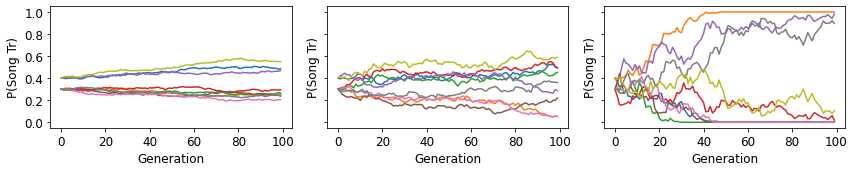

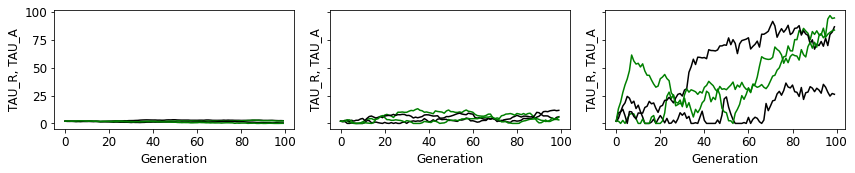

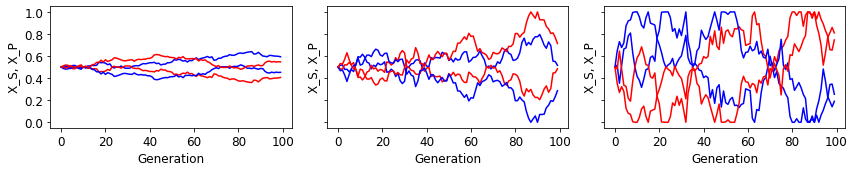

In [3]:
rate_pis = [.0001, .001, .01]
rate_tau_rs = [.1, 1, 5]
rate_tau_as = [.1, 1, 5]
rate_xs = [.01, .04, .1]

fig_pi, ax_pis = plt.subplots(1, 3, figsize=(12, 2.5), tight_layout=True, sharey=True)
fig_tau, ax_taus = plt.subplots(1, 3, figsize=(12, 2.5), tight_layout=True, sharey=True)
fig_x, ax_xs = plt.subplots(1, 3, figsize=(12, 2.5), tight_layout=True, sharey=True)

pi_0 = np.array([
    [.4, .3, .3],
    [.3, .4, .3],
    [.3, .3, .4],
])

N = 2

nrn_param_0 = {
    'TAU_R': np.array([2, 2]),
    'TAU_A': np.array([2, 2]),
    'X_S': np.array([.5, .5]),
    'X_P': np.array([.5, .5]),
}

NGEN = 100

for crate, (rate_pi, rate_tau_r, rate_tau_a, rate_x) in enumerate(zip(rate_pis, rate_tau_rs, rate_tau_as, rate_xs)):
    
    pis = [pi_0.copy()]
    nrn_params = [nrn_param_0]
    
    for cgen in range(1, NGEN):
        pi_next = evolve_pi(pis[cgen-1], rate_pi)
        pis.append(pi_next.copy())
        
        nrn_param_next = evolve_nrn_param(nrn_params[cgen-1], rate_tau_r, rate_tau_a, rate_x)
        nrn_params.append(nrn_param_next)
        
    # plot
    for cel in range(9):
        ax_pis[crate].plot([pi.flatten()[cel] for pi in pis])
        
    for cnrn in range(N):
        ax_taus[crate].plot([nrn_param['TAU_R'][cnrn] for nrn_param in nrn_params], c='k')
        ax_taus[crate].plot([nrn_param['TAU_A'][cnrn] for nrn_param in nrn_params], c='g')
        ax_xs[crate].plot([nrn_param['X_S'][cnrn] for nrn_param in nrn_params], c='b')
        ax_xs[crate].plot([nrn_param['X_P'][cnrn] for nrn_param in nrn_params], c='r')
        
    set_plot(ax_pis[crate], x_label='Generation', y_label='P(Song Tr)')
    set_plot(ax_taus[crate], x_label='Generation', y_label='TAU_R, TAU_A')
    set_plot(ax_xs[crate], x_label='Generation', y_label='X_S, X_P')

# Demo of how song->neural MI changes across generations

In [7]:
RATE_PI = .01
RATE_TAU_R = 3
RATE_TAU_A = 3
RATE_X = .03
NGEN = 100

NT = int(50e3)
NBIN = 9


N = 3

nrn_param_0 = {
    'TAU_R': np.array([10, 10, 10]),
    'TAU_A': np.array([10, 10, 10]),
    'X_S': np.array([.5, .5, .5]),
    'X_P': np.array([.5, .5, .5]),
}

pis = [pi_0.copy()]
nrn_params = [nrn_param_0]
mis = [get_joint_mi(pi_0, nrn_param_0, NT, NBIN)]

for cgen in range(1, NGEN):
    sys.stdout.write('.')
    
    pi_cand = evolve_pi(pis[cgen-1], RATE_PI)
    nrn_param_cand = evolve_nrn_param(nrn_params[cgen-1], RATE_TAU_R, RATE_TAU_A, RATE_X)
    
    mi_cand = get_joint_mi(pi_cand, nrn_param_cand, NT, NBIN)
    
    if mi_cand > .99*mis[-1]:
        pis.append(pi_cand.copy())
        nrn_params.append(copy(nrn_param_cand))
        
    else:
        pis.append(pis[-1].copy())
        nrn_params.append(copy(nrn_params[-1]))
    
    mis.append(mi_cand)

...................................................................................................

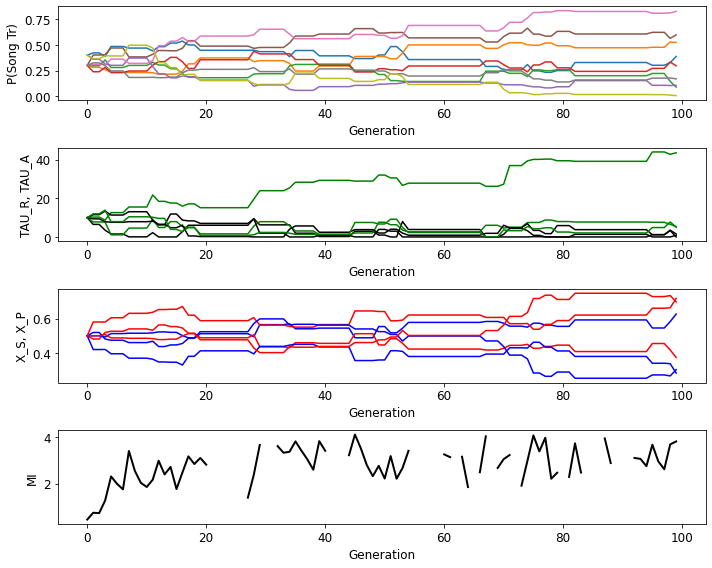

In [8]:
fig, axs = plt.subplots(4, 1, figsize=(10, 8), tight_layout=True)
    
for cel in range(9):
    axs[0].plot([pi.flatten()[cel] for pi in pis])

for cnrn in range(N):
    axs[1].plot([nrn_param['TAU_R'][cnrn] for nrn_param in nrn_params], c='k')
    axs[1].plot([nrn_param['TAU_A'][cnrn] for nrn_param in nrn_params], c='g')
    axs[2].plot([nrn_param['X_S'][cnrn] for nrn_param in nrn_params], c='b')
    axs[2].plot([nrn_param['X_P'][cnrn] for nrn_param in nrn_params], c='r')

set_plot(axs[0], x_label='Generation', y_label='P(Song Tr)')
set_plot(axs[1], x_label='Generation', y_label='TAU_R, TAU_A')
set_plot(axs[2], x_label='Generation', y_label='X_S, X_P')

    
axs[3].plot(mis, c='k', lw=2)
set_plot(axs[3], x_label='Generation', y_label='MI')

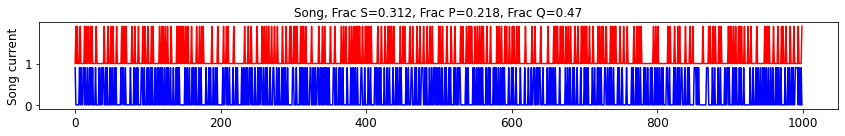

In [9]:
# make song
i_s, i_p, song = sample_song(pis[-1], 1000)

fig, ax = plt.subplots(1, 1, figsize=(12, 2), tight_layout=True, sharex=True)
ax.plot(i_s*.9, c='b')
ax.plot(i_p*.9 + 1, c='r')
set_plot(ax, y_label='Song current', title=f'Song, Frac S={np.mean(i_s)}, Frac P={np.mean(i_p)}, Frac Q={np.mean(1-i_p-i_s)}')